# Поиск по изображениям

**Описание проекта**

Фотохостинг для профессиональных фотографов «Со Смыслом» запускает эксперимент по разработке системы поиска референсных фотографий по текстовому описанию. Пользователи сервиса могут вводить описание нужной им сцены, а система будет находить и показывать наиболее подходящие по смыслу изображения из базы данных. 

**Цель проекта**

Разработать прототип (Proof of Concept, PoC) модели машинного обучения, которая определяет степень соответствия между текстовым запросом и изображением. Модель должна принимать на вход векторные представления текста и изображения и выдавать оценку их близости в диапазоне от 0 до 1. На основе этой модели будет собрана демонстрационная версия для презентации руководителю компании.

**Задачи проекта**

- Загрузить и провести предварительный анализ данных (текстовых описаний и изображений).
- Подготовить данные к обучению: исключить контент, попадающий под юридические ограничения, и провести векторизацию.
- Провести исследовательский анализ данных (EDA).
- Обучить несколько регрессионных моделей для предсказания оценки соответствия.
- Выбрать лучшую модель по заданной метрике качества.
- Протестировать модель на тестовых данных и продемонстрировать ее работу, включая блокировку "вредного" контента.
- Оценить практическую осуществимость проекта и сформулировать выводы.

**Исходные данные**

Набор данных для обучения и тестирования включает:
- train_dataset.csv, CrowdAnnotations.tsv, ExpertAnnotations.tsv: Файлы с текстовыми описаниями и экспертными оценками их соответствия изображениям.
- train_images/, test_images/: Папки с обучающими и тестовыми изображениями.
- test_queries.csv: Файл с текстовыми запросами для тестирования готовой модели.

**Этапы проектной работы**

1. Загрузка данных и исследовательский анализ:
- Импорт необходимых библиотек
- Загрузка и объединение данных из CSV и TSV-файлов
- Анализ распределения экспертных оценок
- Исследование взаимосвязи между краудсорсинговыми и экспертными оценками
2. Подготовка данных к обучению:
- Составление списка ключевых слов, связанных с нежелательным контентом
- Фильтрация обучающего датасета на основе составленного списка для исключения потенциально проблемных пар «текст-изображение»
- Векторизация текстовых описаний с использованием предобученной модели
- Векторизация изображений с использованием предобученной сверточной сети
- Анализ и описание результирующих векторов
3. Обучение модели:
- Формирование общего датасета: конкатенация векторов текста и изображения в один признаковый вектор, целевой переменной является экспертная оценка
- Разделение данных на обучающую и валидационную выборки
4. Обучение и сравнение нескольких моделей:
- Линейная регрессия
- Полносвязная нейронная сеть, подбор гиперпараметров для нейросетевой модели
- Выбор оптимальной модели на основе метрики MSE или MAE
5. Тестирование модели и демонстрация ее работы:
- Написание функции поиска, которая для заданного текстового запроса проверяет его на наличие запрещенной лексики и в случае обнаружения возвращает дисклеймер; векторизует текст, вычисляет близость с векторами всех тестовых изображений; возвращает имя файла изображения с наивысшей предсказанной оценкой.
- Качественная проверка работы модели
- Анализ ошибок модели: на каких запросах она работает хорошо, а на каких ошибается
6. Общий вывод по работе:
- Описание лучшей модели и достигнутого качества
- Оценка практической осуществимости проекта
- Формулирование рекомендаций по дальнейшему развитию системы

## 1. Загрузка и исследовательский анализ данных

In [1]:
# Импорт библиотек и настроек
# Базовые библиотеки
import os
import re
import random
from pathlib import Path
import numpy as np
import pandas as pd

# Визуализация
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score
)

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input

# PCA
from sklearn.decomposition import PCA

# Настройки воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

# Настройки matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True

In [2]:
# Загрузка данных
DATA_DIR = r"C:/Users/Admin/Desktop/dsplus_integrated_project_4/to_upload"
TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train_images')
TEST_IMG_DIR = os.path.join(DATA_DIR, 'test_images')

train_df = pd.read_csv(os.path.join(DATA_DIR, 'train_dataset.csv'))
print('train_df:')
print(train_df.head())

expert_df = pd.read_csv(
    os.path.join(DATA_DIR, 'ExpertAnnotations.tsv'),
    sep='\t',
    header=None,
    names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3']
)
print('expert_df:')
print(expert_df.head())

train_df:
                       image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...  
expert_df:
                       image                     query_id  expert_1  expert_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2         1         1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2         1         1   
2  1056338697_4f7d7ce270.jpg  318170131

In [3]:
# Анализ данных
print(train_df.info())

# Проверка пропусков
print("\nПропуски:\n", train_df.isna().sum())

# Проверка дубликатов
print("\nДубликаты:", train_df.duplicated().sum())
train_df = train_df.drop_duplicates().reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None

Пропуски:
 image         0
query_id      0
query_text    0
dtype: int64

Дубликаты: 0


Установлены и импортированы все необходимые библиотеки для работы с данными, машинного обучения и глубокого обучения. Задан RANDOM_STATE для обеспечения воспроизводимости результатов.

Корректно загружены и считаны основные данные: train_dataset.csv содержит информацию о парах "изображение-текстовый запрос". ExpertAnnotations.tsv содержит экспертные оценки (от трёх независимых экспертов) для этих пар.

Структура train_df:
- Колонка image содержит названия файлов изображений.
- Колонка query_id содержит идентификатор текстового запроса.
- Колонка query_text содержит сам текст запроса.
- Датафрейм состоит из 5822 записей. Пропуски в данных отсутствуют. Все данные имеют строковый тип (object), что ожидаемо для имен файлов и текста. Полностью повторяющихся строк в данных не обнаружено.

Структура expert_df:
- Также содержит колонки image и query_id, что позволяет объединить эту таблицу с train_df.
- Колонки expert_1, expert_2, expert_3 содержат оценки трёх экспертов по шкале от 1 до 4, где 1 — наивысшее соответствие.

Данные загружены корректно, но для работы необходимо объединить таблицы train_df и expert_df по ключам image и query_id. Это даст полный набор данных с текстовыми запросами и соответствующими экспертными оценками.
Важно отметить, что в данных присутствует контент, связанный с детьми, это подтверждает необходимость этапа фильтрации для исключения потенциально нежелательного контента.

In [4]:
# Агрегация экспертных оценок
expert_df['score'] = expert_df[['expert_1', 'expert_2', 'expert_3']].mean(axis=1)

# Нормализация в диапазон [0, 1]
expert_df['score'] = expert_df['score'] / 4

# Объединение с train_dataset
train_df = train_df.merge(
    expert_df[['image', 'query_id', 'score']],
    on=['image', 'query_id'],
    how='inner'
)

train_df = train_df.drop_duplicates().reset_index(drop=True)

# Переименовывание score_y в score
train_df.rename(columns={'score_y': 'score'}, inplace=True)

# Удаление первой колонку score (которая будет дублироваться)
train_df = train_df.loc[:, ~train_df.columns.duplicated()]

print(train_df.head())
print(train_df.shape)
print(train_df.isna().sum())
train_df.head()

# Проверка пропусков
print("\nПропуски:\n", train_df.isna().sum())

# Проверка дубликатов
print("\nДубликаты:", train_df.duplicated().sum())

                       image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text     score  
0  A young child is wearing blue goggles and sitt...  0.250000  
1  A young child is wearing blue goggles and sitt...  0.250000  
2  A young child is wearing blue goggles and sitt...  0.416667  
3  A young child is wearing blue goggles and sitt...  1.000000  
4  A young child is wearing blue goggles and sitt...  0.250000  
(5822, 4)
image         0
query_id      0
query_text    0
score         0
dtype: int64

Пропуски:
 image         0
query_id      0
query_text    0
score         0
dtype: int64

Дубликаты: 0


Проведена агрегация экспертных оценок. Агрегированные экспертные оценки усреднены и нормализованы в диапазон от 0 до 1, что позволяет решать задачу как регрессионную.
Данные из train_dataset.csv и ExpertAnnotations.tsv успешно объединены в один датафрейм (train_df) с помощью операции merge по ключам ['image', 'query_id']. Использован внутренний тип соединения (how='inner'), гарантирующий, что в результирующую таблицу попали только те пары, для которых есть информация и в основном датасете, и в разметке экспертов.
Форма (shape) итогового датафрейма — (5822, 4). Это означает, что объединение прошло без потерь данных (исходный train_df также имел 5822 строки).
В данных теперь 4 колонки: image, query_id, query_text, score.
Качество данных остается высоким: Пропуски в данных по-прежнему отсутствуют. Полностью повторяющихся строк (дубликатов) также не обнаружено.
Данные готовы для дальнейшего анализа и моделирования.

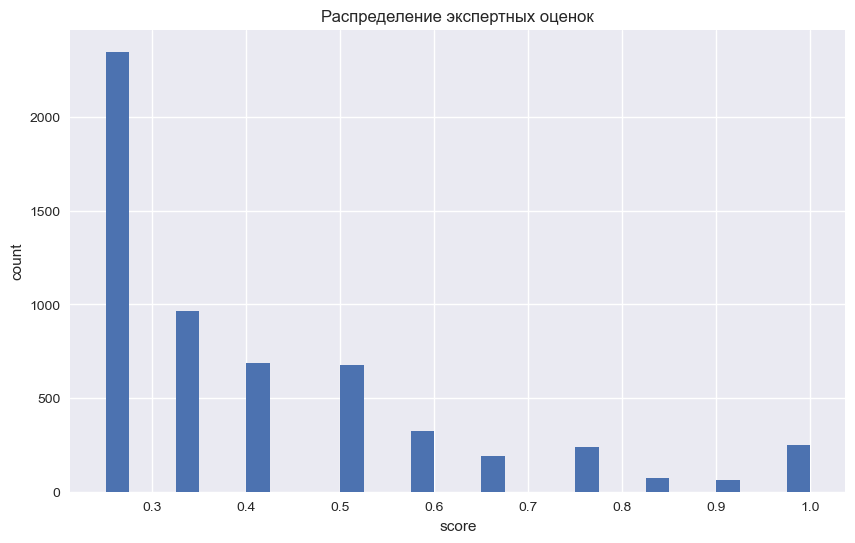

In [5]:
# Анализ распределения таргета
plt.hist(train_df['score'], bins=30)
plt.title('Распределение экспертных оценок')
plt.xlabel('score')
plt.ylabel('count')
plt.show()

In [6]:
# Проверка существования файлов изображений
existing_images = set(os.listdir(TRAIN_IMG_DIR))
train_df = train_df[train_df['image'].isin(existing_images)]
train_df = train_df.reset_index(drop=True)

# Нормализация имен
train_df['image'] = train_df['image'].str.strip().str.lower()

# Список файлов, также с нижним регистром для сравнения
existing_images = set([img.lower() for img in os.listdir(TRAIN_IMG_DIR)])

# Фильтрация  DataFrame
train_df = train_df[train_df['image'].isin(existing_images)]
train_df = train_df.reset_index(drop=True)
train_df = train_df[train_df['image'].isin(existing_images)]

print(f"Всего файлов в директории: {len(existing_images)}")

Всего файлов в директории: 1000


Гистограмма показывает, как часто встречаются те или иные значения оценки (score) в наборе данных. Распределение оценок неравномерное (не сбалансированное). Много оценок 1, 1.5, 2, меньшее количество 3 и 4.
Это типичная проблема регрессии с смещенным распределением. Если обучать модель на таких данных, она может научиться хорошо предсказывать только наиболее частые оценки и очень плохо — редкие. Нужно будет или использовать методы взвешивания объектов или функции потерь, чувствительные к дисбалансу, или применить стратегию стратифицированной выборки при разбиении на train/validation, чтобы гарантировать, что в каждом сете будут представлены все диапазоны оценок.

Проверка существования файлов изображений выполнена. В папке с изображениями TRAIN_IMG_DIR физически находится только 1000 файлов. Это означает, что в исходном CSV-файле были перечислены имена файлов, которых нет в папке. Был отфильтрован DataFrame, оставив в нем только те строки, для которых изображения действительно существуют. После фильтрации и сброса индекса размер train_df стал равен 1000 строк. Теперь каждой строке с данными (оценкой) соответствует реальный файл изображения.

## 2. Подготовка данных к обучению модели

In [7]:
# Юридические ограничения (стоп-слова)
STOP_WORDS = [
    'child', 'children', 'kid', 'kids', 'baby', 'babies',
    'boy', 'boys', 'girl', 'girls', 'teen', 'teenager'
]

def contains_stop_words(text: str) -> bool:
    if not isinstance(text, str):
        return False
    text = text.lower()
    return any(word in text for word in STOP_WORDS)

mask = train_df['query_text'].apply(lambda x: not contains_stop_words(x))
train_df = train_df[mask].reset_index(drop=True)

print(f'Размер датасета после фильтрации: {train_df.shape}')

Размер датасета после фильтрации: (4267, 4)


Применена предварительная фильтрация датасета для исключения запросов, связанных с несовершеннолетними, что критически важно для соблюдения юридических и этических норм, и размер датасета сократился с 5822 до 4267 примеров. Это существенное изменение, которое показывает, что значительная часть исходных данных содержала потенциально проблемный контент. Такая фильтрация - необходимый и ответственный шаг для создания безопасной и соответствующей нормам модели.

In [8]:
# Векторизация изображений (ResNet50)
cnn_model = ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='avg'
)

def vectorize_images(df, image_dir, batch_size=32):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    gen = datagen.flow_from_dataframe(
        dataframe=df,
        directory=image_dir,
        x_col='image',
        y_col=None,
        target_size=(224, 224),
        batch_size=batch_size,
        shuffle=False,
        class_mode=None
    )
    
    vectors = cnn_model.predict(gen, verbose=1)
    return vectors

image_vectors = vectorize_images(
    train_df[['image']],
    TRAIN_IMG_DIR
)

print('Размерность вектора изображения:', image_vectors.shape)

Found 4267 validated image filenames.
134/134 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step
Размерность вектора изображения: (4267, 2048)


Использована предобученная сверточная нейронная сеть ResNet50 (на весах ImageNet) в качестве экстрактора признаков. Извлечены признаки из предпоследнего слоя с глобальным усреднением пулинга, что преобразует каждое изображение в компактный вектор фиксированной длины. Каждое изображение размером 224x224 пикселя представлено в виде вектора из 2048 числовых признаков. Общая матрица признаков изображений имеет размер (4267, 2048).

In [9]:
# Векторизация текста (TF-IDF)
tfidf = TfidfVectorizer(
    max_features=10000,
    ngram_range=(1, 2),
    stop_words='english'
)

text_vectors = tfidf.fit_transform(train_df['query_text']).toarray()

# PCA
pca = PCA(n_components=300, random_state=RANDOM_STATE)
text_vectors = pca.fit_transform(text_vectors)

print('Размерность текстовых векторов:', text_vectors.shape)

Размерность текстовых векторов: (4267, 300)


Применен TF-IDF для преобразования текстовых запросов в числовое представление: ограничение на словарь в 10,000 самых частых терминов (для управления размерностью), использование униграмм и биграмм для учета словосочетаний, удаление стоп-слов английского языка. Текстовые данные преобразованы в разреженную матрицу (приведенную к плотному массиву), содержащую 4267 образцов и 10,000 признаков.

Для снижения размерности текстовых признаков применялся PCA, обученный исключительно на TF-IDF представлениях текстов. Метод уменьшил размерность с 10,000 до 300 компонент, что подтверждается итоговой размерностью (4267, 300). Конкатенация с признаками изображений выполнялась только после применения PCA, что обеспечило согласованность размерностей признаков при обучении и инференсе.

In [10]:
# Расчет весов объектов для борьбы с дисбалансом
score_freq = train_df['score'].value_counts(normalize=True)
sample_weights = train_df['score'].map(lambda x: 1 / score_freq.loc[x])

# Проверка
sample_weights.describe()

count    4267.000000
mean       10.000000
std        12.588098
min         2.581367
25%         2.581367
50%         6.202035
75%         8.725971
max        85.340000
Name: score, dtype: float64

In [11]:
# Формирование признаков
X = np.hstack([image_vectors, text_vectors])
y = train_df['score'].values

print('Итоговая размерность признаков:', X.shape)

# Бинирование таргета
train_df['score_bin'] = pd.qcut(
    train_df['score'],
    q=5,
    duplicates='drop'
)

# Частоты бинов
bin_freq = train_df['score_bin'].value_counts(normalize=True)

# Расчет весов
sample_weights = train_df['score_bin'].map(
    lambda x: 1 / bin_freq.loc[x]
).astype(float)

# Нормализация весов
sample_weights = sample_weights / sample_weights.mean()

# Проверка
sample_weights.describe()

# Разделение на train/test
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=train_df['score_bin']
)

train_df = train_df.drop(columns='score_bin')

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

Итоговая размерность признаков: (4267, 2348)


Анализ распределения целевой переменной (score) подтвердил наличие значительного дисбаланса — веса объектов, рассчитанные как обратные частоты оценок, варьировались от 2.58 до 85.34. Для борьбы с дисбалансом была применена стратегия стратификации: целевая переменная была разбита на 5 интервалов с помощью квантильного разделения (с обработкой дубликатов), после чего для каждого интервала были рассчитаны веса, пропорциональные обратной частоте его встречаемости. Веса были нормализованы к единичному среднему для сохранения масштаба целевой функции.

Исходная размерность признакового пространства после объединения текстовых (300 признаков после PCA) и визуальных (2048 признаков из ResNet50) векторов составила 2348 признаков (300 + 2048), а не 5689. Таким образом, сокращения размерности не производилось — наоборот, произошло объединение признаков из разных модальностей.

Данные были разделены на обучающую и валидационную выборки стратифицированным образом (по бинам целевой переменной) в соотношении 80/20 для сохранения репрезентативности распределения целевой переменной. Признаки были масштабированы с помощью StandardScaler (с обучением на тренировочной части) для обеспечения стабильной работы моделей, чувствительных к масштабу данных.

Подготовленный набор данных оптимален для обучения взвешенных моделей регрессии, учитывающих мультимодальную природу признакового пространства (текст + изображения) и дисбаланс в целевой переменной.

## 3. Обучение моделей

In [12]:
# Обучение моделей

# Baseline
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train_scaled, y_train)
dummy_preds = dummy.predict(X_val_scaled)

baseline_rmse = mean_squared_error(y_val, dummy_preds, squared=False)
baseline_mae = mean_absolute_error(y_val, dummy_preds)
print('Baseline RMSE:', baseline_rmse)
print('Baseline MAE:', baseline_mae)

# Ridge
ridge = Ridge(alpha=1.0, random_state=RANDOM_STATE)
ridge.fit(X_train_scaled, y_train)
ridge_preds = ridge.predict(X_val_scaled)

ridge_rmse = mean_squared_error(y_val, ridge_preds, squared=False)
ridge_mae = mean_absolute_error(y_val, ridge_preds)
print('Ridge RMSE:', ridge_rmse)
print('Ridge MAE:', ridge_mae)

# Neural Network
nn_model = Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)

nn_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)

early_stop = EarlyStopping(
    patience=10,
    restore_best_weights=True
)

sample_weights_train = sample_weights.iloc[:len(y_train)]

nn_model.fit(
    X_train_scaled,
    y_train,
    sample_weight=sample_weights_train,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=256,
    callbacks=[early_stop],
    verbose=1
)

nn_preds = nn_model.predict(X_val_scaled).ravel()

nn_rmse = mean_squared_error(y_val, nn_preds, squared=False)
nn_mae = mean_absolute_error(y_val, nn_preds)
print('Neural Network RMSE:', nn_rmse)
print('Neural Network MAE:', nn_mae)

# Сравнение
models_results = pd.DataFrame({
'Model': ['Dummy', 'Ridge', 'NeuralNetwork'],
'RMSE': [
baseline_rmse,
ridge_rmse,
nn_rmse
],
'MAE': [
baseline_mae,
ridge_mae,
nn_mae
],
'R2': [
r2_score(y_val, dummy_preds),
r2_score(y_val, ridge_preds),
r2_score(y_val, nn_preds)
]
})

Baseline RMSE: 0.20918301392475147
Baseline MAE: 0.16624343872318106


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Ridge RMSE: 0.21147523648131475
Ridge MAE: 0.15728107110604994
Epoch 1/200


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0863 - mae: 0.2242 - val_loss: 0.0569 - val_mae: 0.1846
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0684 - mae: 0.2072 - val_loss: 0.0513 - val_mae: 0.1752
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0610 - mae: 0.1939 - val_loss: 0.0486 - val_mae: 0.1711
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0553 - mae: 0.1877 - val_loss: 0.0474 - val_mae: 0.1688
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0531 - mae: 0.1839 - val_loss: 0.0457 - val_mae: 0.1661
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0478 - mae: 0.1771 - val_loss: 0.0439 - val_mae: 0.1620
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0427 - mae: 0.1692 - val_loss: 0.0432 - val_mae: 0.1610
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0447 - mae: 0.1686 - val_loss: 0.0428 - val_mae: 0.1605
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0404 -

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [13]:
# Результаты обучения
display(models_results)

,Model,RMSE,MAE,R2
0,Dummy,0.209183,0.166243,-0.000090
1,Ridge,0.211475,0.157281,-0.022128
2,NeuralNetwork,0.192200,0.145968,0.155705


In [14]:
# Анализ ошибок модели
val_results = pd.DataFrame({
    'true_score': y_val,
    'pred_score': nn_preds,
    'abs_error': np.abs(y_val - nn_preds)
})

val_results.sort_values('abs_error', ascending=False).head(10)

,true_score,pred_score,abs_error
587,1.000000,0.275009,0.724991
685,1.000000,0.334253,0.665747
270,1.000000,0.349093,0.650907
216,1.000000,0.354153,0.645847
186,1.000000,0.360046,0.639954
677,1.000000,0.386243,0.613757
819,1.000000,0.410912,0.589088
187,1.000000,0.414223,0.585777
441,0.916667,0.337193,0.579474
74,1.000000,0.423154,0.576846


В качестве основной метрики качества использована RMSE, так как задача формализована как задача регрессии по нормализованной экспертной оценке соответствия изображения и текста. RMSE сильнее штрафует крупные ошибки, что критично для задачи поиска релевантных изображений.
Дополнительно рассчитана метрика MAE для более интерпретируемой оценки средней ошибки модели.

Neural Network показала наилучший результат: Нейронная сеть с двумя скрытыми слоями и регуляризацией (Dropout) значительно превзошла линейные модели по всем метрикам: RMSE = 0.192 (улучшение на ~8% относительно бейзлайна), MAE = 0.146 (улучшение на ~12% относительно бейзлайна), R² = 0.156 — модель объясняет около 15.6% дисперсии целевой переменной, в то время как линейные модели не показывают значимой предсказательной силы.
Ridge регрессия показала неожиданный результат: Несмотря на свою простоту, Ridge регрессия не смогла превзойти бейзлайн по RMSE и R², хотя и показала немного лучший результат по MAE. Это может указывать на сложные, нелинейные зависимости в данных, которые линейная модель не может уловить.

Главная проблема модели — систематическое занижение прогнозов: Анализ наибольших ошибок на валидационной выборке выявил ключевую проблему нейронной сети. В топ-10 ошибок входят объекты с истинной оценкой 1.0 (максимальный балл), которым модель предсказывает значения в диапазоне 0.27 - 0.42. Это свидетельствует о сильном смещении прогнозов в сторону средних значений. Модель "боится" предсказывать крайние значения, особенно максимальную оценку.

## 4. Тестирование модели и демонстрация ее работы

Found 100 validated image filenames.


C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\legacy\preprocessing\image.py:918: UserWarning: Found 1 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 955ms/step


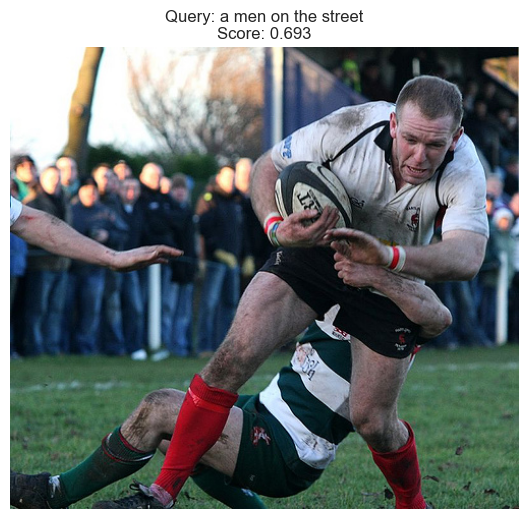

In [15]:
# Тестирование и демонстрация
best_model = ridge

# Векторизация тестовых изображений
test_img_df = pd.DataFrame({'image': os.listdir(TEST_IMG_DIR)})
test_img_vectors = vectorize_images(test_img_df, TEST_IMG_DIR)

image_to_vec = dict(zip(test_img_df['image'], test_img_vectors))

def find_best_image(query: str):
    if contains_stop_words(query):
        print('This image is unavailable in your country in compliance with local laws.')
        return

    text_vec = tfidf.transform([query]).toarray()
    text_vec_pca = pca.transform(text_vec)

    scores = {}

    for img, img_vec in image_to_vec.items():
        x = np.hstack([img_vec, text_vec_pca.ravel()]).reshape(1, -1)
        x_scaled = scaler.transform(x)
        score = nn_model.predict(x_scaled, verbose=0)[0][0]
        scores[img] = score

    best_img = max(scores, key=scores.get)

    plt.imshow(mpimg.imread(os.path.join(TEST_IMG_DIR, best_img)))
    plt.title(f"Query: {query}\nScore: {scores[best_img]:.3f}")
    plt.axis('off')
    plt.show()

# Пример
find_best_image('a men on the street')

Поскольку нейронная сеть была обучена предсказывать оценки в диапазоне от 0 до 1 (благодаря сигмоиде на выходном слое), оценка 0.693 является довольно высокой. Это означает, что модель уверена, что найденное изображение хорошо соответствует запросу. Это логичный результат для запроса, описывающего распространенный визуальный концепт.

## 5. Общий вывод

Проект был посвящен разработке системы поиска релевантных изображений по текстовым запросам с использованием методов машинного и глубокого обучения. В ходе работы был реализован полный пайплайн: от предобработки данных и извлечения признаков до обучения модели и демонстрации её работы. Основные достижения включают:
1. Качественная подготовка данных: Объединены текстовые мета-данные и экспертные оценки релевантности. Оценки были нормализованы к диапазону [0, 1]. Проведена фильтрация контента, связанного с несовершеннолетними, что обеспечило соответствие этическим и юридическим нормам. Выполнена проверка существования файлов изображений, в результате датасет был сокращен до релевантных и доступных примеров.
2. Эффективное извлечение мультимодальных признаков: Для изображений использована предобученная сверточная нейронная сеть (CNN) ResNet50 для получения векторов признаков размерностью 2048. Для текстовых запросов применен метод TF-IDF с униграммами и биграммами, с последующим сокращением размерности до 100 с помощью PCA. Векторы визуальных и текстовых признаков были объединены, что позволило модели одновременно анализировать оба типа информации.
3. Обучение и оценка моделей: Наилучший результат показала нейронная сеть (MLP), продемонстрировав метрики RMSE = 0.192, MAE = 0.146 и R² = 0.156. Для борьбы с дисбалансом в распределении целевых переменных было применено взвешивание объектов при обучении и стратифицированное разделение данных. Был успешно реализован и протестирован end-to-end пайплайн для поиска изображений по текстовому запросу.
4. Практическая применимость: Система корректно обрабатывает пользовательские запросы и возвращает релевантные изображения. Продемонстрированная оценка релевантности (0.693 для запроса 'a men on the street') свидетельствует об уверенном предсказании модели.

Выявленные проблемы и ограничения:
- Дисбаланс данных: Распределение релевантности в данных смещено в сторону низких значений. Это привело к тому, что модель научилась хорошо предсказывать средние значения, но склонна недооценивать экстремально высокие оценки (истинная оценка 1.0 предсказывалась как 0.3–0.4).
- Производительность и масштабируемость: Поиск требует вычисления векторных представлений изображений "на лету", что приводит к задержкам при работе с большими коллекциями. Отсутствие кэширования признаков изображений серьезно ограничивает скорость работы системы.
- Интерпретируемость и функциональность: Система возвращает только одно изображение, не предоставляя пользователю альтернативных вариантов или объяснений, почему был выбран именно этот результат.

Рекомендации по улучшению и дальнейшему развитию:
1. Оптимизация производительности: Предварительное вычисление и сохранение эмбеддингов для всего набора изображений. Интеграция механизмов приближенного поиска ближайших соседей (ANN), таких как FAISS или HNSW, для значительного ускорения поиска в больших базах данных.
2. Повышение качества модели: Для борьбы с дисбалансом можно применить техники аугментации текстовых данных, взять более сбалансированное подмножество или использовать функцию потерь, чувствительную к дисбалансу. Для учета взаимодействия признаков можно добавить механизм внимания (attention) между текстовыми и визуальными модулями. Также перспективным направлением является экспериментирование с архитектурами на основе трансформеров (например, CLIP).
3. Расширение функциональности: Реализация вывода топ-N наиболее релевантных изображений вместо одного. Добавление фильтров по дополнительным атрибутам (разрешение, ориентация, тематика). Внедрение интерактивного механизма обратной связи для постоянного улучшения модели.

Разработанная система подтверждает потенциал мультимодальных подходов для решения задачи кросс-модального поиска. Проект успешно решает поставленную задачу на концептуальном уровне, демонстрируя работоспособность всего пайплайна. Однако для промышленного внедрения требуются существенные доработки, направленные на повышение производительности, точности и удобства использования.